In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [3]:
nodes = pd.read_csv('data/nodes.csv')
edging = pd.read_csv('data/edging.csv')



In [4]:
nodes['typ'].value_counts()

typ
substation          437
auxillary_T_node     41
plant                24
generator             9
Name: count, dtype: int64

In [5]:
nodes.head()

,Unnamed: 0,v_id,lon,lat,typ,voltage,frequency,name,operator,ref
0,0,1,9.522576,52.360409,substation,220000;110000,50,Hannover/West,TenneT;EON_Netz,NaN
1,1,2,9.113210,52.543853,substation,220000,50,Umspannwerk Kraftwerk Robert Frank,TenneT,NaN
2,2,3,9.389745,52.026313,substation,380000;110000,50,UW Grohnde 380 kV / 110 kV,TenneT,NaN
3,3,4,9.125266,52.538264,substation,380000;220000,50,Landesbergen,TenneT TSO GmbH,NaN
4,4,5,10.366275,52.284647,substation,380000;220000,50,Wahle,TenneT,NaN


In [6]:
edging.head()

,Unnamed: 0,l_id,v_id_1,v_id_2,voltage,cables,wires,frequency,name,operator,ref,length_m,r_ohmkm,x_ohmkm,c_nfkm,i_th_max_a,from_relation
0,0,1,1,2,220000,3.0,2.0,50.0,Leitung 2016,TenneT,2016,43396,0.0800,0.320,11.5,1.3,67129.0
1,1,2,3,4,380000,3.0,4.0,50.0,Leitung 3011,TenneT,NaN,72714,0.0250,0.250,13.7,2.6,67131.0
2,2,3,5,6,220000,3.0,2.0,50.0,Leitung 2024,TenneT,1,33954,0.0800,0.320,11.5,1.3,67151.0
3,3,4,7,5,380000,3.0,4.0,50.0,Leitung 3026,TenneT,3026,33483,0.0250,0.250,13.7,2.6,67153.0
4,4,5,8,9,380000,6.0,4.0,50.0,KKW Krümmel - UW Lüneburg,TenneT,NaN,28172,0.0125,0.125,27.4,5.2,67585.0


In [7]:

G = nx.Graph()

for i, row in nodes.iterrows():
    G.add_node(row['v_id'], name = row['name'], lon = row['lon'], lat = row['lat'], type = row['typ'])
    
    
for i, row in edging.iterrows():
    G.add_edge(row['v_id_1'], row['v_id_2'], length = row['length_m'], voltage = row['voltage'], cables = row['cables'], wires = row['wires'], name = row['name'])
    
    


In [8]:
nx.write_gexf(G, 'data/power.gexf')

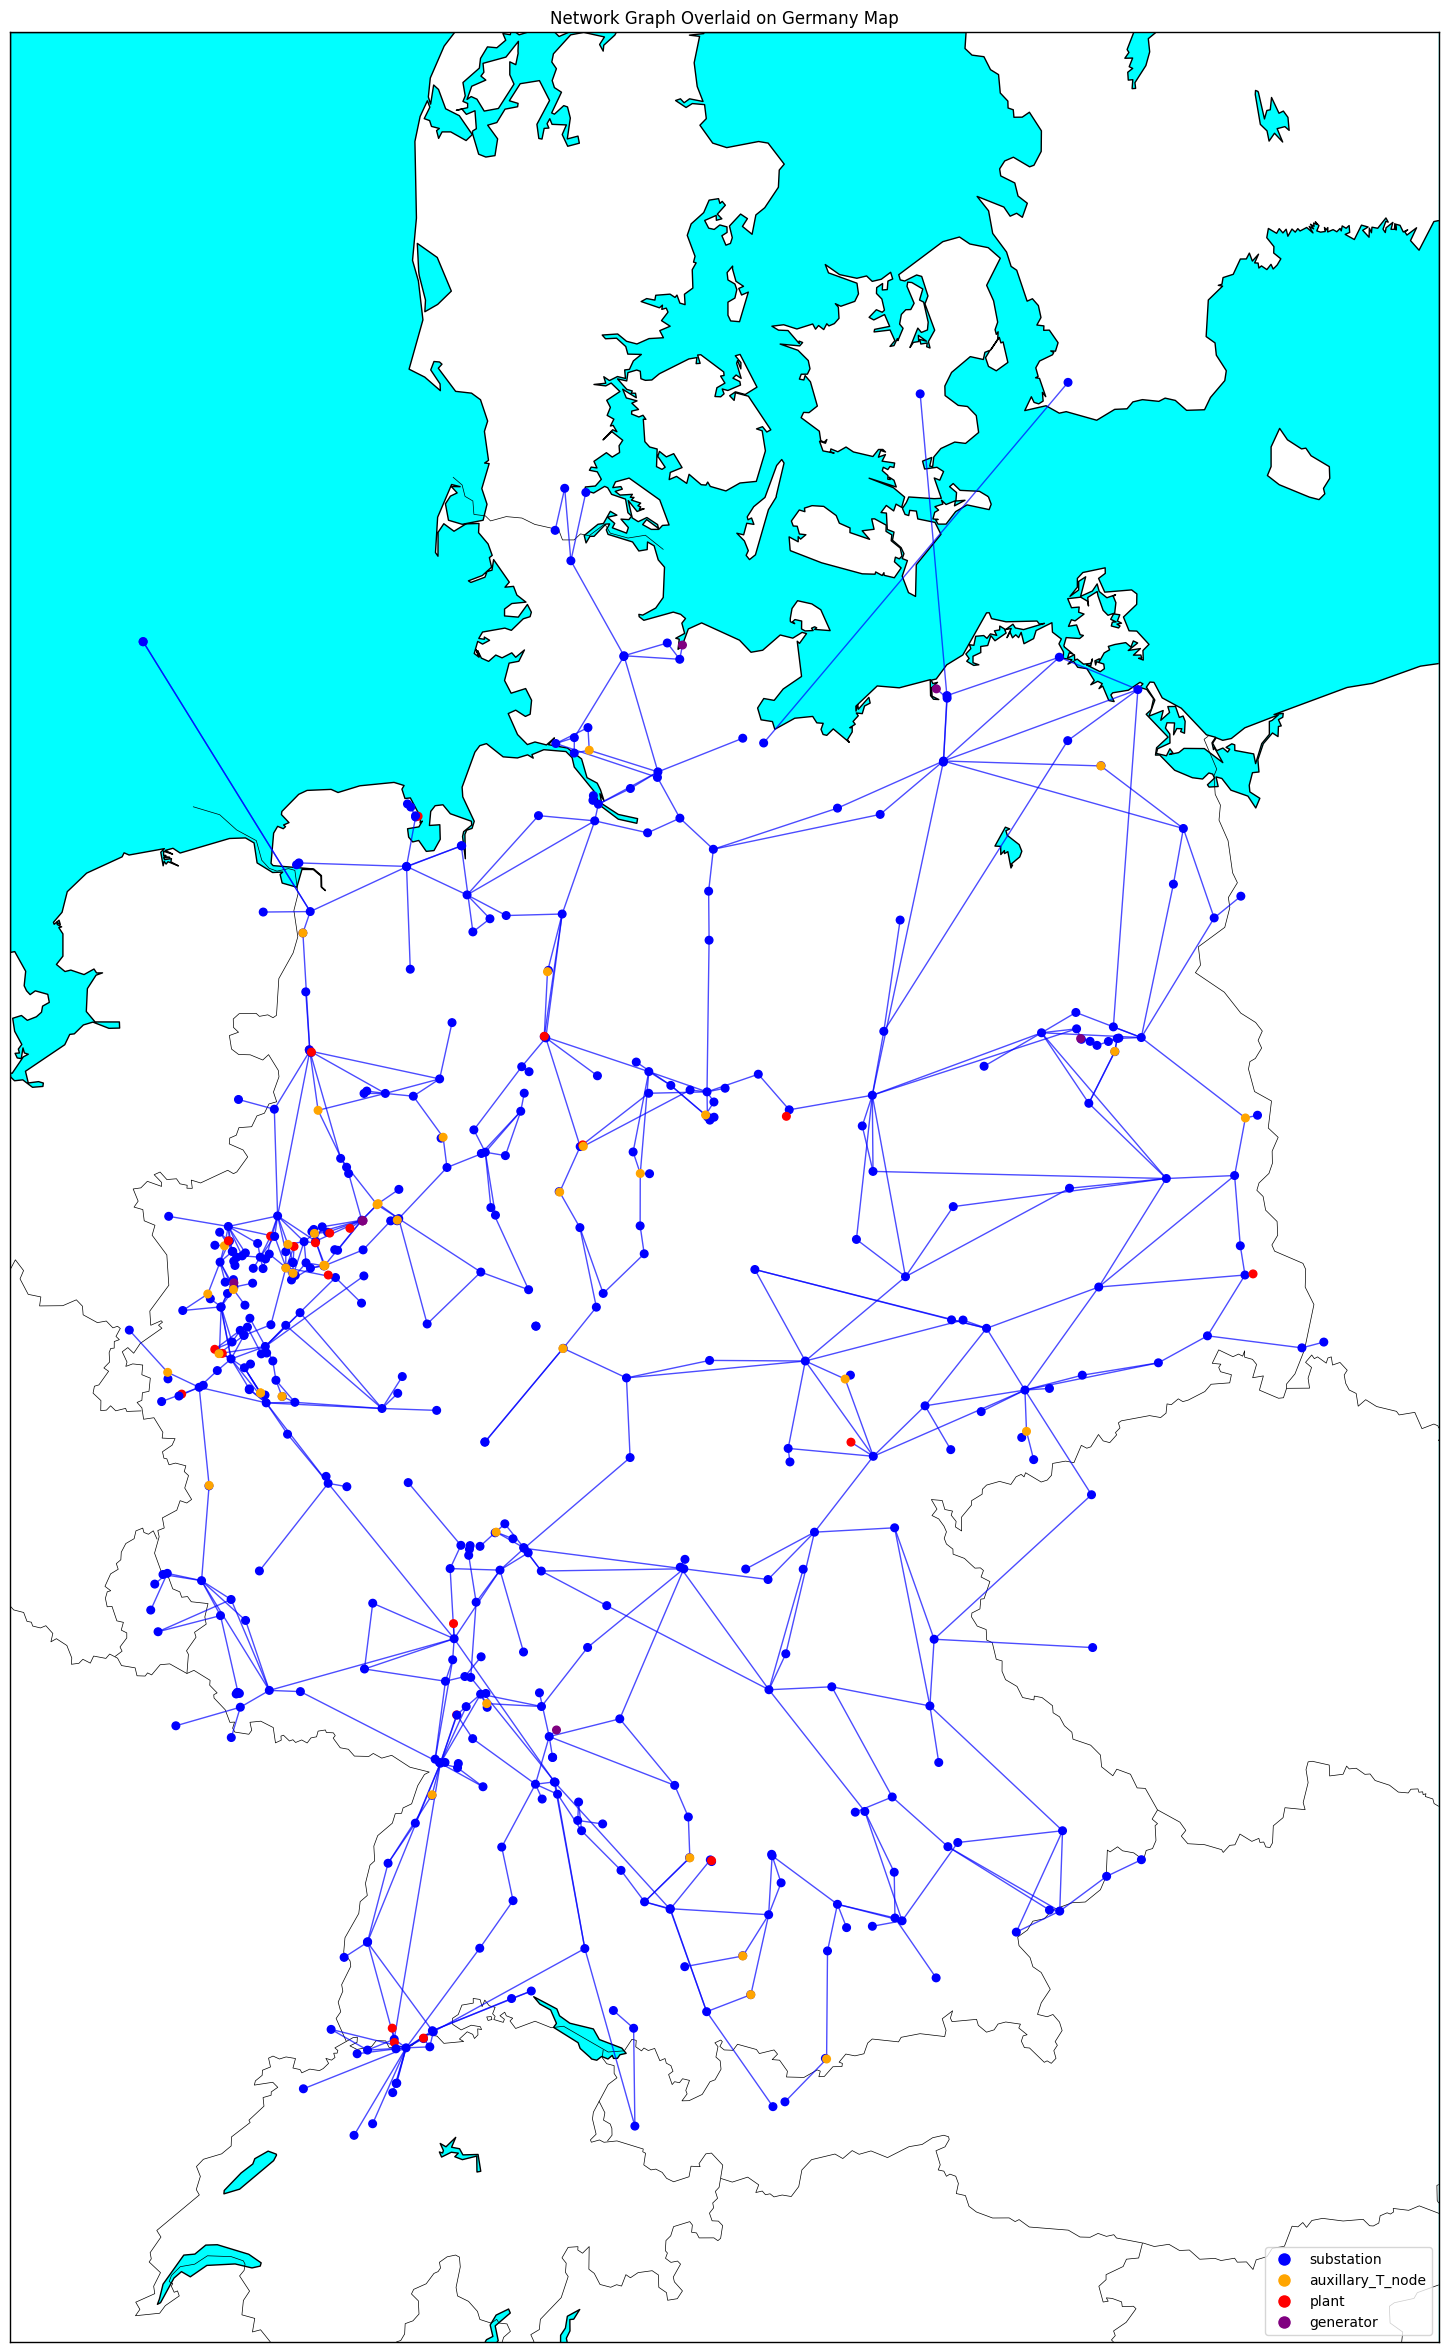

In [13]:
node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}

# Initialize Basemap for Germany
plt.figure(figsize=(20, 30))
m = Basemap(projection='merc', 
            llcrnrlat=46, urcrnrlat=57, 
            llcrnrlon=5, urcrnrlon=16, 
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='white', lake_color='aqua')

# Convert node positions to map projection
mapped_positions = {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}
node_types = {node: data['type'] for node, data in G.nodes(data=True)}
colormap = {'substation':'blue', 'auxillary_T_node':'orange', 'plant':'red', 'generator':'purple'}
node_colors = [colormap[node_types[node]] for node in G.nodes]

# Draw edges
for u, v in G.edges:
    x = [mapped_positions[u][0], mapped_positions[v][0]]
    y = [mapped_positions[u][1], mapped_positions[v][1]]
    plt.plot(x, y, color='blue', linewidth=1, alpha=0.7)

# Draw nodes
x, y = zip(*mapped_positions.values())
plt.scatter(x, y, c=node_colors, s=30, zorder=5)

# Add labels
for node, (lon, lat) in node_positions.items():
    x, y = m(lon, lat)
    # plt.text(x, y, str(node), fontsize=6, ha='right')

handles = [plt.Line2D([0], [0], marker='o', color='w', label=node_type, 
                      markerfacecolor=color, markersize=10) 
           for node_type, color in colormap.items()]
plt.legend(handles=handles, loc='lower right')

plt.title("Network Graph Overlaid on Germany Map")
plt.show()